In [1401]:
# install.packages("Metrics")

In [1402]:
# libraries
library(readxl)
options(warn = 0)
library(tidyverse)
library(readxl)
library(lubridate)
library(zoo)
library(readxl)
library(neuralnet)
library(knitr)
# library(Metrics)

In [1403]:
df <- read_excel("data/UOW_load.xlsx")
head(df)

Dates,09:00,10:00,11:00
<dttm>,<dbl>,<dbl>,<dbl>
2018-01-01,89.4,90.6,88.6
2018-01-02,108.2,104.6,106.0
2018-01-03,110.0,111.6,114.8
2018-01-04,106.4,104.4,109.0
2018-01-05,97.8,100.4,102.4
2018-01-06,87.0,90.8,87.2


In [1404]:
df$Dates<-as.Date(df$Dates)

In [1405]:
names(df)[2] <- paste("ninth_hour")
names(df)[3] <- paste("tenth_hour")
names(df)[4] <- paste("eleventh_hour")
head(df)

Dates,ninth_hour,tenth_hour,eleventh_hour
<date>,<dbl>,<dbl>,<dbl>
2018-01-01,89.4,90.6,88.6
2018-01-02,108.2,104.6,106.0
2018-01-03,110.0,111.6,114.8
2018-01-04,106.4,104.4,109.0
2018-01-05,97.8,100.4,102.4
2018-01-06,87.0,90.8,87.2


In [1406]:
summary(df[2:4])

   ninth_hour       tenth_hour     eleventh_hour   
 Min.   : 50.40   Min.   : 49.20   Min.   : 48.20  
 1st Qu.: 81.55   1st Qu.: 83.00   1st Qu.: 84.75  
 Median : 97.50   Median :102.80   Median :105.40  
 Mean   : 95.35   Mean   : 99.63   Mean   :102.83  
 3rd Qu.:110.60   3rd Qu.:116.05   3rd Qu.:120.90  
 Max.   :141.20   Max.   :148.80   Max.   :156.40  

In [1407]:
# insert all the inputs to the one data frame
# creating revious time frame values for autoregressive model 
df_full = df %>%
 mutate(
    previous_one_day_ninth_hour = lag(df$ninth_hour,1),
    previous_one_day_tenth_hour = lag(df$tenth_hour,1),
    previous_two_day_ninth_hour = lag(df$ninth_hour,2),
    previous_two_day_tenth_hour = lag(df$tenth_hour,2),
    previous_one_day_eleventh_hour = lag(df$eleventh_hour,1),
    previous_two_day_eleventh_hour = lag(df$eleventh_hour,2),
    previous_three_day_eleventh_hour = lag(df$eleventh_hour,3),
    previous_four_day_eleventh_hour = lag(df$eleventh_hour,4),
    seven_day_rolling_mean = rollmean(eleventh_hour,7, fill = NA)) %>%
#Drop null coulumns
drop_na()


In [1408]:
head(df_full)

Dates,ninth_hour,tenth_hour,eleventh_hour,previous_one_day_ninth_hour,previous_one_day_tenth_hour,previous_two_day_ninth_hour,previous_two_day_tenth_hour,previous_one_day_eleventh_hour,previous_two_day_eleventh_hour,previous_three_day_eleventh_hour,previous_four_day_eleventh_hour,seven_day_rolling_mean
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-05,97.8,100.4,102.4,106.4,104.4,110.0,111.6,109.0,114.8,106.0,88.6,100.4571
2018-01-06,87.0,90.8,87.2,97.8,100.4,106.4,104.4,102.4,109.0,114.8,106.0,101.8857
2018-01-07,68.8,67.0,67.6,87.0,90.8,97.8,100.4,87.2,102.4,109.0,114.8,101.8000
2018-01-08,110.2,113.0,116.2,68.8,67.0,87.0,90.8,67.6,87.2,102.4,109.0,102.4286
2018-01-09,111.2,119.2,116.0,110.2,113.0,68.8,67.0,116.2,67.6,87.2,102.4,105.0000
2018-01-10,109.0,114.6,114.2,111.2,119.2,110.2,113.0,116.0,116.2,67.6,87.2,104.6571


## Input vercors

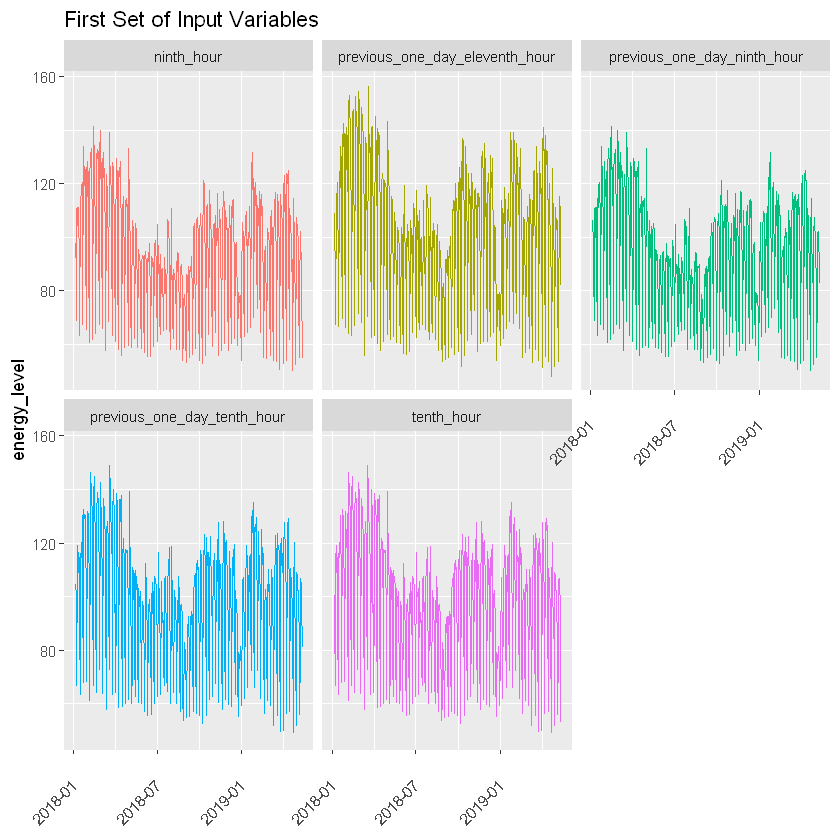

In [1409]:
#1st lag
df_full %>%
pivot_longer(cols = c(2, 3, 5, 6, 9), names_to = "kind", values_to = "energy_level") %>%
ggplot(aes(Dates, energy_level, color = kind)) +
geom_line() +
facet_wrap(~kind) + theme(axis.text.x = element_text(angle = 45, vjust =
0.5, hjust = 1
)) +
labs(x = "",
title = "First Set of Input Variables") +
theme(legend.position = "none")


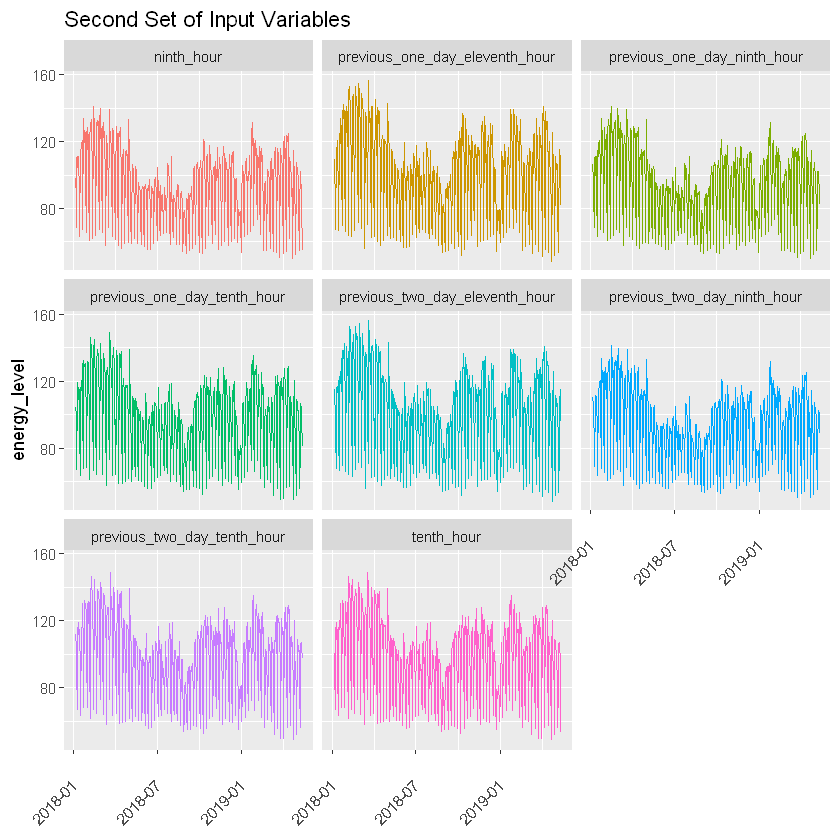

In [1410]:
#2nd lag
df_full %>%
pivot_longer(cols = c(5, 6, 9, 2, 3, 7, 8, 10), names_to = "kind", values_to = "energy_level") %>%
ggplot(aes(Dates, energy_level, color = kind)) +
geom_line() +
facet_wrap(~kind) + theme(axis.text.x = element_text(angle = 45, vjust =
0.5, hjust = 1
)) +
labs(x = "",
title = "Second Set of Input Variables") +
theme(legend.position = "none")

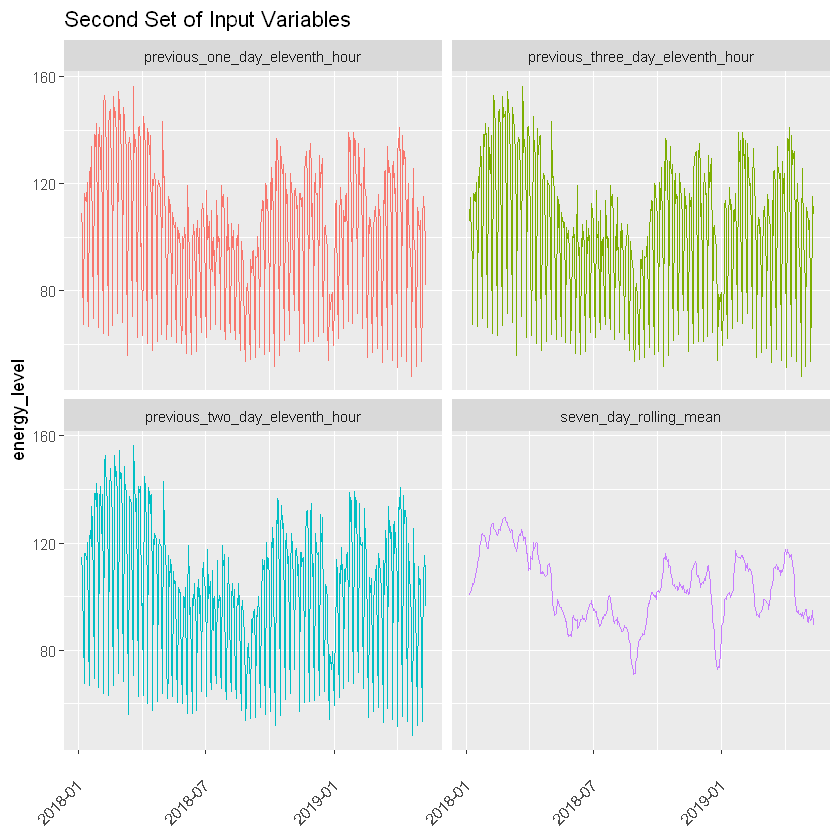

In [1411]:
#3rd lag
df_full %>%
pivot_longer(cols = c(9,10,11,13), names_to = "kind", values_to = "energy_level") %>%
ggplot(aes(Dates, energy_level, color = kind)) +
geom_line() +
facet_wrap(~kind) + theme(axis.text.x = element_text(angle = 45, vjust =
0.5, hjust = 1
)) +
labs(x = "",
title = "Second Set of Input Variables") +
theme(legend.position = "none")

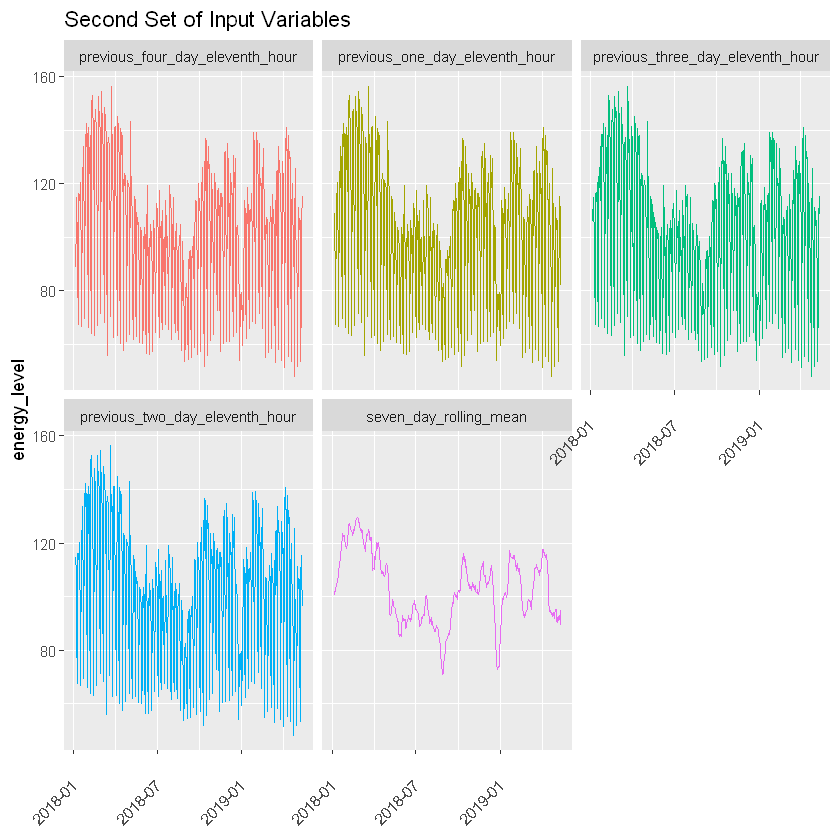

In [1412]:
#4thd lag
df_full %>%
pivot_longer(cols = c(9,10,11,12,13), names_to = "kind", values_to = "energy_level") %>%
ggplot(aes(Dates, energy_level, color = kind)) +
geom_line() +
facet_wrap(~kind) + theme(axis.text.x = element_text(angle = 45, vjust =
0.5, hjust = 1
)) +
labs(x = "",
title = "Second Set of Input Variables") +
theme(legend.position = "none")

# Data Normalization

In [1413]:
head(df_full)

Dates,ninth_hour,tenth_hour,eleventh_hour,previous_one_day_ninth_hour,previous_one_day_tenth_hour,previous_two_day_ninth_hour,previous_two_day_tenth_hour,previous_one_day_eleventh_hour,previous_two_day_eleventh_hour,previous_three_day_eleventh_hour,previous_four_day_eleventh_hour,seven_day_rolling_mean
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-05,97.8,100.4,102.4,106.4,104.4,110.0,111.6,109.0,114.8,106.0,88.6,100.4571
2018-01-06,87.0,90.8,87.2,97.8,100.4,106.4,104.4,102.4,109.0,114.8,106.0,101.8857
2018-01-07,68.8,67.0,67.6,87.0,90.8,97.8,100.4,87.2,102.4,109.0,114.8,101.8000
2018-01-08,110.2,113.0,116.2,68.8,67.0,87.0,90.8,67.6,87.2,102.4,109.0,102.4286
2018-01-09,111.2,119.2,116.0,110.2,113.0,68.8,67.0,116.2,67.6,87.2,102.4,105.0000
2018-01-10,109.0,114.6,114.2,111.2,119.2,110.2,113.0,116.0,116.2,67.6,87.2,104.6571


##### min-max normalization

In [1414]:
z_score = function(x) {
  return((x - mean(x)) / sd(x))
}

x_value = function(z) {
    return((z * sd(df_full$eleventh_hour)) + mean(df_full$eleventh_hour))
}

In [1415]:
df_normalized <- as.data.frame(lapply(df_full[2:13], z_score))
head(df_normalized)

,ninth_hour,tenth_hour,eleventh_hour,previous_one_day_ninth_hour,previous_one_day_tenth_hour,previous_two_day_ninth_hour,previous_two_day_tenth_hour,previous_one_day_eleventh_hour,previous_two_day_eleventh_hour,previous_three_day_eleventh_hour,previous_four_day_eleventh_hour,seven_day_rolling_mean
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1195014,0.03251834,-0.01825154,0.5242374,0.20233458,0.6928496,0.51345265,0.23797574,0.46476076,0.11607696,-0.57010301,-0.19333463
2,-0.3927135,-0.38388537,-0.61654447,0.1149376,0.02811233,0.5215339,0.19972808,-0.02282772,0.23545975,0.46400311,0.11764769,-0.08242189
3,-1.2558904,-1.41621956,-1.38802746,-0.3990669,-0.39002107,0.1122799,0.02543665,-0.62346598,-0.02546898,0.23468815,0.46547562,-0.08907665
4,0.7076000,0.57904821,0.52493546,-1.2652595,-1.42664345,-0.4016670,-0.39286278,-1.39797322,-0.62639576,-0.02625646,0.23622539,-0.04027505
5,0.7550273,0.84797561,0.51706318,0.7050908,0.57691242,-1.2677628,-1.42989677,0.52248860,-1.40127502,-0.62721980,-0.02464556,0.15936788
6,0.6506872,0.64844883,0.44621271,0.7526838,0.84695691,0.7023671,0.57445465,0.51458547,0.52010928,-1.40214621,-0.62543927,0.13274883


In [1416]:
set.seed(123)
df_train <- df_normalized[1:430,]
df_test <- df_normalized[431:493,]

In [1417]:
relevant_pred_stat <- function(true_value, predicted_value, model_kind) {
rbind((tibble(truth = true_value,prediction = predicted_value) %>% rmse(truth,prediction) %>% mutate(type = model_kind)),
    (tibble(truth = true_value,prediction = predicted_value) %>% mape(truth,prediction) %>% mutate(type = model_kind)),
    (tibble(truth = true_value,prediction = predicted_value) %>% mae(truth,prediction) %>% mutate(type = model_kind)))
}

In [1418]:
model_one_hidden_layer = function(arg, hidden_first, activation_fun, learningrate, test_data) {
    one_layer_nurelnet = neuralnet(arg,
    data=df_train, 
    hidden = c(hidden_first), 
    linear.output = TRUE, 
    act.fct = activation_fun,
    learningrate = learningrate
    )
    results = compute(one_layer_nurelnet, test_data)
    truth_column = df_full[431:493, 4]$eleventh_hour
    predicted_column =  x_value(results$net.result)[,1]
    
    relevant_pred_stat(truth_column, predicted_column,"Two Hidden Layers") %>% mutate(hidden_layers = paste0(hidden_first), input_set = "A")
}

In [1419]:
model_two_hidden_layer = function(arg, hidden_first, hidden_second, activation_fun, learningrate, test_data) {
    one_layer_nurelnet = neuralnet(arg,
    data=df_train, 
    hidden = c(hidden_first, hidden_second), 
    linear.output = TRUE, 
    act.fct = activation_fun,
    learningrate = learningrate
    )
    results = compute(one_layer_nurelnet, test_data)
    truth_column = df_full[431:493, 4]$eleventh_hour
    predicted_column =  x_value(results$net.result)[,1]
       
}

In [1420]:
  model_one_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+previous_one_day_ninth_hour+previous_one_day_tenth_hour+previous_one_day_eleventh_hour", 
        2, 
        "logistic", 
        NULL,
        df_test[, c(1, 2, 4, 5, 8)]
                        )

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'print': non-numeric argument to binary operator


construct one hidden layer models with fixed all parameters without input sets to evaluate best input set

In [ ]:
neuralnet_first_inset = lapply(1:10, function(n){ 
    model_one_hidden_layer(
        "eleventh_hour~ninth_hour+tenth_hour+previous_one_day_ninth_hour+previous_one_day_tenth_hour+previous_one_day_eleventh_hour", 
        n, 
        "logistic", 
        NULL,
        df_test[, c(1, 2, 4, 5, 8)]
                        )
    })

[1] "RMSE :"
[1] "RMSE :"
[1] "RMSE :"
[1] "RMSE :"
[1] "RMSE :"
[1] "RMSE :"
[1] "RMSE :"
[1] "RMSE :"
[1] "RMSE :"
[1] "RMSE :"
